In [1]:
import csv
from collections import defaultdict
import pandas as pd
import numpy as np
from itertools import product

In [2]:
filename = '/Users/carlosejimenez/Downloads/muxing results - speed_plot.tsv'

In [3]:
def get_relevant_column_names_2_idxs(line):
    col_2_idxs = {v: k for k, v in dict(list(enumerate(line))).items()}
    return col_2_idxs

In [4]:
def extract_entries(column_name_idxs, line, layer, dim):
    model_dict = {'layers': layer, 'dim': dim, 'num_sentences': int(line[0])}
    entries = defaultdict(dict)
    for (passes_num, column), idx in column_name_idxs.items():
        if '.' in set(line[idx]):
            entries[passes_num][column] = float(line[idx])
        else:
            try:
                entries[passes_num][column] = int(line[idx])
            except:
                entries[passes_num][column] = np.nan
    l_entries = list()
    for passes_num, entry in entries.items():
        l_entries.append(entry | model_dict | {'passes': passes_num})
    return l_entries

In [5]:
# def get_start(line):
#     first_entry = line[0]
#     if '+' in first_entry:
#         model, demuxer, muxer = list(map(str.strip, first_entry.split('+')))
#         num_passes = None
#         passes_dict = dict()
#         passes_columns = list()
#         for ix, entry in enumerate(line):
#             if entry.startswith('forward passes'):
#                 if num_passes is not None:
#                     passes_dict[num_passes] = passes_columns
#                 num_passes = int(entry.split('=')[-1])
#             if num_passes is None:
#                 continue
#             else:
#                 passes_columns.append(ix)
#         if num_passes is not None:
#             passes_dict[num_passes] = passes_columns
#         return model, demuxer, muxer, passes_dict
#     else:
#         return None

In [6]:
def get_start(line):
    first_entry = line[0]
    if '+' in first_entry and 'layer' in first_entry and 'dim' in first_entry:
        layer = first_entry.split('layer')[0].strip()
        dim = first_entry.split('layer')[-1].split('dim')[0].strip()
        num_passes = None
        passes_dict = dict()
        for ix, entry in enumerate(line):
            if entry.startswith('forward passes'):
                num_passes = int(entry.split('=')[-1])
            if num_passes is None:
                
                continue
            else:
                passes_dict[ix] = num_passes
        return layer, dim, passes_dict
    else:
        return None

In [7]:
data = list()
muxer = None
demuxer = None
is_start = False
column_name_idxs = dict()
reader = csv.reader(open(filename), delimiter='\t')
for ix, line in enumerate(reader):
    if ix < 2 or not any(list(map(len, line))):
        continue
    start_values = get_start(line)
    if start_values is not None:
        layer, dim, passes_dict = start_values
        column_name_idxs = dict()
        is_start = True
    elif is_start:
        is_start = False
        for ix, column in enumerate(line):
            if len(column) and ix > 0:
                column_name_idxs[(passes_dict[ix], column)] = ix
    elif not line[0].startswith('rtx_2080'):
        try:
            data.extend(extract_entries(column_name_idxs, line, layer, dim,))
        except Exception as e:
            print(e)
            print(f'Failed to extract entry for line {ix}: \n{line}\n')

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# CONSTANTS to use for plots
import toml
constants = toml.load('plot_constants.toml')
FACE_COLOR = constants['FACE_COLOR']
MARKER = constants['MARKER']
LINEWIDTH = constants['LINEWIDTH']
MARKERSIZE = constants['MARKERSIZE']
MARKEREDGEWIDTH = constants['MARKEREDGEWIDTH']
XLABEL_FONTSIZE = constants['XLABEL_FONTSIZE']
TITLE_FONTSIZE = constants['TITLE_FONTSIZE']
BASELINE_COLOR = constants['BASELINE_COLOR']
BASELINE_LABEL_COLOR = constants['BASELINE_LABEL_COLOR']
COLORS = constants['COLORS']
sns.set_style('whitegrid')
sns.set(rc={'axes.facecolor':FACE_COLOR,})
sns.set_context("paper", font_scale=2.1, )

['-0.2x', '0.0x', '0.2x', '0.4x', '0.6x', '0.8x', '1.0x', '1.2x']
['-5x', '0x', '5x', '10x', '15x', '20x', '25x', '30x']


/var/folders/ns/6gmmvd6s5qg9jxmtwgpfvhf00000gn/T/ipykernel_18113/1830788577.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(labels=list(map(lambda x: f'{x:.1f}x', g.get_yticks())))
/var/folders/ns/6gmmvd6s5qg9jxmtwgpfvhf00000gn/T/ipykernel_18113/1830788577.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(labels=list(map(lambda x: f'{x:.0f}x', g.get_yticks())))


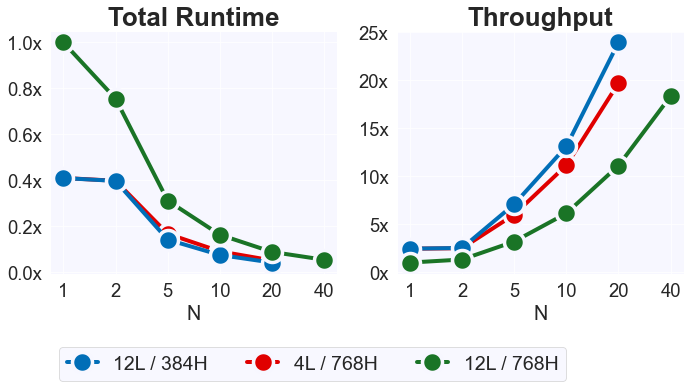

In [44]:
# %%capture
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df = pd.DataFrame(data)
max_idxs = list()
for layer, dim, sents in list(product(set(df['layers']), set(df['dim']), set(df['num_sentences']))):
    sub_df = df[(df['layers'] == layer) & (df['dim'] == dim) & (df['num_sentences'] == sents)]
    if not sub_df.empty:
        max_idxs.append(sub_df['mnli_eval_throughput'].idxmax())
df = df.loc[max_idxs]
df.loc[df['num_sentences'] == 1, 'num_sentences']  = 0
df.loc[df['num_sentences'] == 2, 'num_sentences']  = 1
df.loc[df['num_sentences'] == 5, 'num_sentences']  = 2
df.loc[df['num_sentences'] == 10, 'num_sentences'] = 3
df.loc[df['num_sentences'] == 20, 'num_sentences'] = 4
df.loc[df['num_sentences'] == 40, 'num_sentences'] = 5
df['Model'] = df['layers'] + 'L / ' + df['dim'] + 'H'
# df = df.drop(columns=['mnli_total_samples'])
baseline_inference_time = df[(df['layers'] == '12') & (df['dim'] == '768') & (df['num_sentences'] == 0)]['mnli_eval_inference_time'].item()
baseline_throughput = df[(df['layers'] == '12') & (df['dim'] == '768') & (df['num_sentences'] == 0)]['mnli_eval_throughput'].item()
df['mnli_eval_inference_time'] = df['mnli_eval_inference_time'] / baseline_inference_time
df['mnli_eval_throughput'] = df['mnli_eval_throughput'] / baseline_throughput

df = df.rename(columns={'num_sentences': 'N','mnli_eval_inference_time': 'Total Runtime', 'mnli_eval_throughput': 'Throughput'})
df = df.drop(df[((df['Model'] == '12L / 384H') | (df['Model'] == '4L / 768H')) & (df['N'] == 5)].index)
colors = sns.color_palette(COLORS)

for ix, column in enumerate(['Total Runtime', 'Throughput']):
    g = sns.lineplot(
        data=df,
        x='N',
        y=column,
        palette=[colors[1], colors[0], colors[2]],
        hue='Model',
        ax=axs[ix],
        marker=MARKER,
        legend='auto',
        markersize=MARKERSIZE,
        linewidth=LINEWIDTH,
        markeredgewidth=MARKEREDGEWIDTH,
        markeredgecolor=FACE_COLOR,
    )
    
    g.set_xlabel('N', fontsize=0.9*XLABEL_FONTSIZE)
    g.set_ylabel('', fontsize=0)
    g.set_title(column, fontsize=TITLE_FONTSIZE, weight='bold')

    header_name=[1, 2, 5, 10, 20, 40]
    x_tick_interval = 1
    value_tick = range ( 0, 6, x_tick_interval )
    header_name_sel = [header_name[idx] for idx in  range ( 0,len(value_tick))]

    handles, labels = g.get_legend_handles_labels()
    
    g.get_legend().remove()
    labels = g.get_xticklabels() # get x labels
    g.set_xticks(ticks=value_tick) # set new labels
    g.set_xticklabels(labels=header_name)
    if ix == 0:
        g.set_yticklabels(labels=list(map(lambda x: f'{x:.1f}x', g.get_yticks())))
        print(list(map(lambda x: f'{x:.1f}x', g.get_yticks())))
    else:
        print(list(map(lambda x: f'{x:.0f}x', g.get_yticks())))
        g.set_yticklabels(labels=list(map(lambda x: f'{x:.0f}x', g.get_yticks())))
    
# g._legend.remove()
[ha.set_linewidth(LINEWIDTH) for ha in handles ]

for ix in range(len(handles)):
    handle = handles[ix]
    handle.set_marker(MARKER)
    handle.set_markersize(MARKERSIZE)
    handle.set_markeredgewidth(MARKEREDGEWIDTH)
    handle.set_markeredgecolor(FACE_COLOR)

# g.fig.legend(handles, labels, ncol=1, bbox_to_anchor=(0.9, 0.3), frameon=True, handlelength=1.3, fontsize=24)
fig.legend(handles=[handles[1], handles[0], handles[2]], ncol=3, bbox_to_anchor=(0.82, 0.02), frameon=True, handlelength=1.6, fontsize=0.75*TITLE_FONTSIZE)

fig.tight_layout()

In [45]:
fig.savefig('mux_charts/speed_plots.pdf', bbox_inches='tight')